In [141]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import models 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.stats import lognorm
from scipy.stats import norm

In [142]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
cut = 1300
train_data_x , train_data_y  = train_data.iloc[:cut,1:-1].copy(), train_data.iloc[:cut,-1].copy()
val_data_x , val_data_y = train_data.iloc[cut:,1:-1].copy(), train_data.iloc[cut:,-1].copy()
test_data_x  = test_data


In [143]:
def gaus(x, mean,std):##Gaussian
    return 1/(std*(2*np.pi)**0.5)*np.exp(-0.5*((x-mean)/std)**2)

def bin_bisect(bins):## Bin Bisector 
    bisects = np.zeros(len(bins)-1)
    for i in range(len(bins)-1):
        bisects[i] = (bins[i]+bins[i+1])/2
    return(bisects)

def rss(observed,expected):##Chisquared value 
    return(np.sum((observed-expected)**2))

All numerical data can be easily normalized. 
for the non nunmerical entries, The number of unique entries should be considered. 

To Do
-Plot input data 
-stdev

180983.51461538463
1.2151782995734465e-11
1.5721638628623447e-10


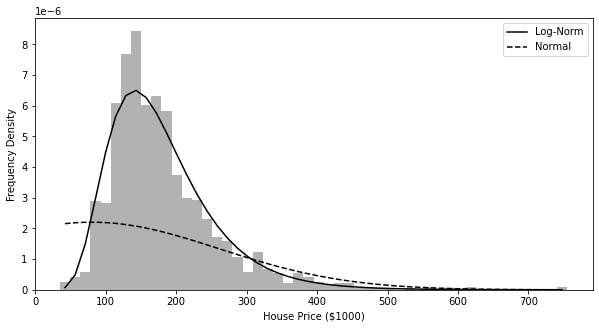

In [303]:

bin_bisects = bin_bisect(bins)
sigma, mean, scale = lognorm.fit(train_data_y)
sigma_norm, mean_norm = np.mean(train_data_y), np.std(train_data_y)
fit_norm = gaus(bin_bisects,mean_norm,sigma_norm)
fit = lognorm.pdf(bin_bisects, sigma, scale = scale)

print(np.mean(train_data_y))
##Plotting 
fig = plt.figure(figsize=(10,5))
vals, bins , _ = plt.hist(train_data_y,50, density= True, color = 'black', alpha = 0.3)
plt.plot(bin_bisects, fit, c = 'black', label = 'Log-Norm')
plt.plot(bin_bisects, fit_norm, c = 'black',linestyle = '--', label = 'Normal')
plt.xticks(range(0,800000,100000),range(0,800,100))
plt.xlabel('House Price ($1000)')
plt.ylabel('Frequency Density')
## Fits 
print(rss(vals,fit))
print(rss(vals,fit_norm))
plt.legend()
fig.savefig('../Kaggle_Housing_Figures/Data_Dist.png',dpi = 300)

In [222]:
###Finding MAE with random variables distributed according to the pdf 

random_variable = lognorm.rvs(sigma,loc = mean,size = len(val_data_y)*1000,scale = scale)
rv_mean = np.zeros(1000)
for i in range(1000):
    chunk = random_variable[160*i:160*(i+1)]
    rv_mean[i] = np.mean(abs(val_data_y -random_variable[160*i:160*(i+1)]))

print(np.mean(rv_mean))
print(np.std(rv_mean))

80605.28403286888
4531.727983978054


## Functions For Processing Input data 
Data is normalised either with some form of gaussian or between 0-1 depending on what it is

I am going to remove the top 5% of house prices. I think that ftting a lognorm dist is going to be the best bet for this. 

In [145]:
##excluding top 5%
#index = np.where(train_data_y < np.percentile(train_data_y,95))

#train_data_y , train_data_x    = train_data_y.iloc[index], train_data_x.iloc[index]
#train_data_x  = np.delete(train_data_x,drop_index)


In [146]:
def atributes_to_int(series):
    unique_ent = pd.unique(series)
    num_unique_ent = len(unique_ent)
    for i in range(num_unique_ent):
        index = np.where(unique_ent[i] == series)
        series.iloc[index] = i
    return series/num_unique_ent ### I divided by the number of unique entries so that all the values in the input columns are between 0-1

def normalise(series):
    mean = np.mean(series)
    std = np.std(series)
    if std == 0:
        return (series - mean)
    else:
        return((series - mean)/std)

def column_processor(series):
    
    #series = series.fillna(0)
    if series.dtype == object:
        norm_series = atributes_to_int(series)
    if series.dtype == int or float:
        norm_series = normalise(series)
    return norm_series

def process_input_data(data):
    data = data.fillna(0)
    for i in range(len(data.iloc[0])):
        data.iloc[:,i] = column_processor(data.iloc[:,i])
    return data

In [147]:
train_data_x = process_input_data(train_data_x)
val_data_x = process_input_data(val_data_x)

/home/sean/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [148]:
print(pd.unique(train_data_x['Alley']))
#print(train_data_x.columns)

[-0.23661361647023868 2.509794431845032 5.256202480160303]


## Neural Net

In [226]:
def build_model(num_layers,layer_size):
    model = models.Sequential()
    model.add(layers.Dense(layer_size[0],activation= 'relu',input_shape = (train_data_x.shape[1],)))
    for i in range(1,num_layers):
        model.add(layers.Dense(layer_size[i],activation = 'relu'))
    model.add(layers.Dense(1))
    opt = keras.optimizers.SGD(learning_rate= .01)
    model.compile(optimizer = opt,loss = 'mse', metrics = ['mae'])
    return model

In [299]:
model = build_model(2,[128,128])
history = model.fit(train_data_x,train_data_y, validation_data= (val_data_x,val_data_y),epochs = 50,batch_size = 80,verbose = 0)
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_113 (Dense)            (None, 128)               10240     
_________________________________________________________________
dense_114 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_115 (Dense)            (None, 1)                 129       
Total params: 26,881
Trainable params: 26,881
Non-trainable params: 0
_________________________________________________________________


In [298]:
start = 10
mae = history.history['val_mean_absolute_error']
print(np.min(mae))
mae = mae[start:]

epochs = range(1,51)
epochs = epochs[start:]
train_err = history.history['loss']
train_err = train_err[start:]

56933.668


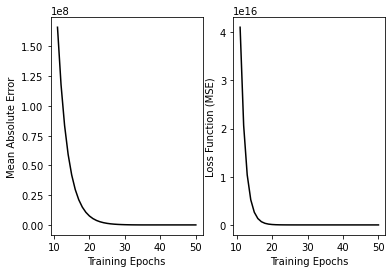

In [302]:
fig, axs = plt.subplots(1,2,)
axs[0].plot(epochs,mae, label = 'Mean Absolute Error', c = 'black')
axs[1].plot(epochs,train_err, label = 'Loss Function',c = 'black')

axs[0].set_ylabel('Mean Absolute Error')
axs[1].set_ylabel('Loss Function (MSE)')
axs[0].set_xlabel('Training Epochs')
axs[1].set_xlabel('Training Epochs')
fig.savefig('../Kaggle_Housing_Figures/Inital Test.png',dpi = 300)


Using the adam optimiser, which is like rsmprop, but with a momentum effect does reduce the error faster. Editing the learning rate to 0.1 gives a much faster fitting.  

20462.574


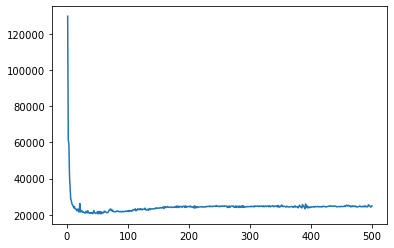

In [153]:
start  = 0
mae_slice  = mae[start:]
epochs_slice = epochs[start:]
plt.plot(epochs_slice,mae_slice)
print(np.min(mae))


Editing Hyperparams to see if I can get a better value than for 256,256

22182.209


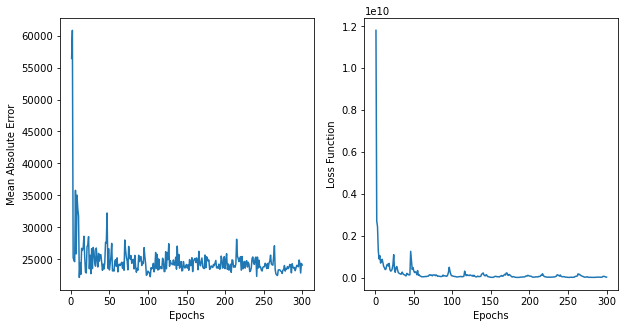

In [154]:
def hyperparam_investigator(epoch_num, layer_num,layer_shape,start = 0):
    
    model = build_model(layer_num,layer_shape)
    history = model.fit(train_data_x,train_data_y, validation_data= (val_data_x,val_data_y),epochs = epoch_num ,batch_size = 32,verbose = 0)
    mae = history.history['val_mean_absolute_error']
    train_err = history.history['loss']
    epochs = range(1,epoch_num+1)
    fig ,axs = plt.subplots(1,2, figsize = (10,5))
    axs[0].set_ylabel('Mean Absolute Error')
    axs[0].set_xlabel('Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss Function')
    mae_slice  = mae[start:]
    train_err_slice = train_err[start:]
    epochs_slice = epochs[start:]
    axs[0].plot(epochs_slice,mae_slice)
    axs[1].plot(epochs_slice,train_err_slice)
    print(np.min(mae))
hyperparam_investigator(300,3,[256,256,256])

21307.473


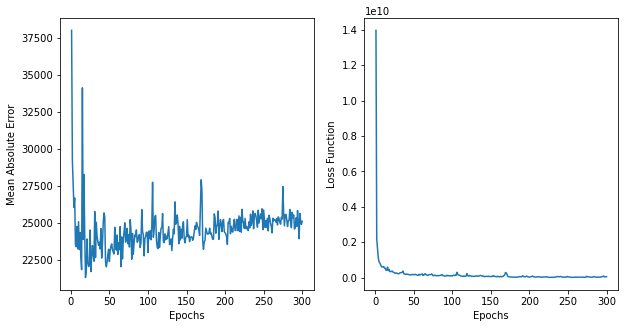

In [155]:
hyperparam_investigator(300,2,[128,128])

Adding a further Layer did not help with minimising the mae, I think just fiddling with the hyperparameters this evening is going to be a good idea

21026.844


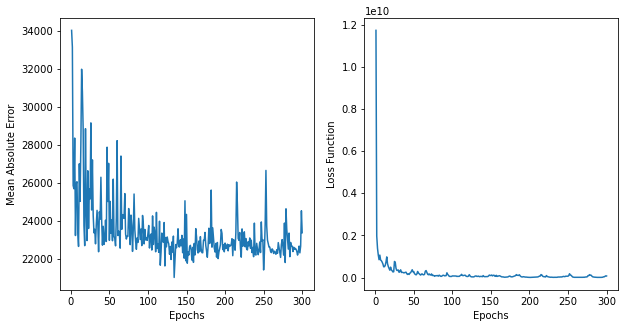

In [156]:
hyperparam_investigator(300,3,[128,128,128])

21443.115


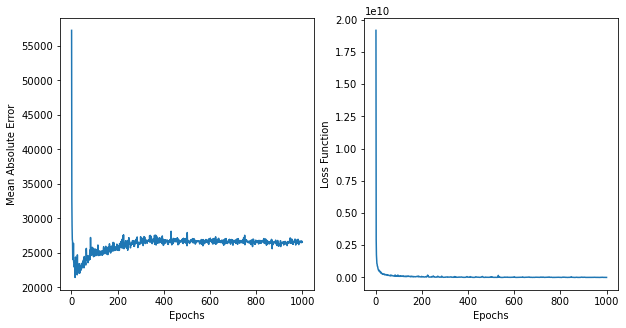

In [157]:
hyperparam_investigator(1000,2,[64,64])

This is worth keeping clearly shows the overtraining. The results are worse than the first test. This is probably due to the lack of degrees of freedom that this model has. 

21805.832


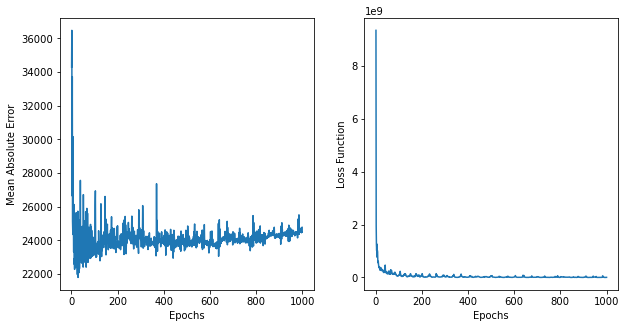

In [158]:
hyperparam_investigator(1000,2,[128*3,128*3])

I think that this minimum is anomalous and this larger network is not the solution 

21391.98


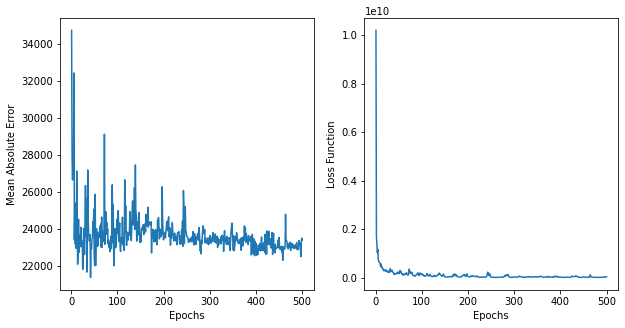

In [159]:
hyperparam_investigator(500,2,[256,256])